In [68]:
from selenium import webdriver
from selenium.webdriver.firefox.options import Options
options = Options()
options.binary_location = 'geckodriver'


In [69]:
import time
from urllib.request import Request, urlopen
from urllib.error import HTTPError

# Define la URL base
base_url = "https://www.infocasas.com.uy/alquiler/inmuebles/pagina"

# Número total de páginas
total_pages = 50

# Lista para almacenar el HTML de cada página
html_base = []

# Set the number of retries
max_retries = 3

# Set the initial delay between retries
retry_delay = 1

# Itera sobre todas las páginas
for page_number in range(1, total_pages + 1):
    # Construye la URL completa para la página actual
    url = f"{base_url}{page_number}"

    # This packages the request
    request = Request(url)

    # Retry the request for a maximum number of times
    for retry in range(max_retries):
        try:
            # Sends the request and catches the response: response
            response = urlopen(request)

            # Extract the response: html
            html = response.read()

            # Agrega el HTML al array html_data
            html_base.append(html)

            # Be polite and close the response!
            response.close()

            # Break out of the loop if the request is successful
            break

        except HTTPError as e:
            # Print the error message
            print(f"HTTP Error: {e.code} - {e.reason}")

            # Retry after a delay
            time.sleep(retry_delay)

            # Increase the delay for the next retry
            retry_delay *= 2

    else:
        # If all retries fail, print an error message
        print(f"Maximum number of retries reached for page {page_number}. Request failed.")



In [70]:
from bs4 import BeautifulSoup

# Create an empty array to store the processed HTML elements
sopita = []

# Loop through each html_code element
for html in html_base:
    soup = BeautifulSoup(html, 'lxml')

    sopita.append(soup)

In [71]:
    links_array = []

    for soup in sopita:
        links = soup.find_all('a', class_='lc-cardCover')
        links_array.extend(links)

In [72]:
urls = [link['href'] for link in links_array]
urls = [f"https://www.infocasas.com.uy{link}" for link in urls]

In [73]:
len(urls)

1050

In [74]:
options = Options()
options.binary_location = 'geckodriver'

# Iniciar el navegador Firefox
driver = webdriver.Firefox(options=options)
html_data = []  # Initialize an empty array to store HTML data
for url in urls:
    driver.get(url)
    html_data.append(driver.page_source)  # Save the HTML data to the array


In [75]:
prices = []
for html in html_data:
    price_element = BeautifulSoup(html, 'lxml').find('span', class_='ant-typography price')
    if price_element:
        price = price_element.text
        prices.append(price)
    else:
        prices.append('N/A')  # Add a placeholder value if the element is not found


In [76]:
gastos_list = []

for html in html_data:
    gastos_tags = BeautifulSoup(html, 'lxml').find_all('span', class_='ant-typography ant-typography-secondary commonExpenses')
    if gastos_tags:  # Verificar si hay elementos encontrados
        gastos_text = ''.join(tag.text for tag in gastos_tags)  # Unir el texto de todos los elementos encontrados
        gastos_list.append(gastos_text)
    else:
        gastos_list.append('0')  # Agregar '0' si no se encontraron elementos

In [77]:
casas_list = []
for html_casas in html_data:
    casas = BeautifulSoup(html_casas, 'lxml')
    features = casas.find_all('div', class_='ant-row ant-row-space-between')
    casas_list.append(features)


In [78]:
# Crear un arreglo vacío para almacenar los datos de cada casa
casas = []

# Iterar sobre cada lista de casas en casas_list
for houses in casas_list:
    # Crear un arreglo vacío para almacenar los datos de la casa actual
    casa_actual = []
    
    # Iterar sobre cada casa en la lista actual
    for house in houses:
        # Extraer las características de la casa
        nombre = house.find_all('div', class_='ant-col')[0].text[2:]
        valor = house.find_all('div', class_='ant-col')[2].text
        
        # Agregar las características de la casa actual al arreglo
        casa_actual.append((nombre, valor))
    
    # Agregar el arreglo de características de la casa actual al arreglo de datos de casas
    casas.append(casa_actual)

# Ahora, casas_data contiene un arreglo para cada casa, donde cada elemento del arreglo es una tupla (nombre, valor) representando una característica de la casa.


In [79]:
for i in range(len(casas)):
    casas[i].append(('Precio', prices[i]))


In [187]:
import pandas as pd

# Suponiendo que casas es una lista de listas, donde cada sublista contiene tuplas (nombre, valor) que representan las características de una casa

# Crear un conjunto para almacenar todos los nombres de características encontrados en todas las casas
todos_los_nombres = set()
for casa in casas:
    for nombre, _ in casa:
        todos_los_nombres.add(nombre)

# Crear un diccionario para almacenar los valores de las características para cada casa
datos_dict = {}
for i, casa in enumerate(casas):
    casa_dict = dict(casa)
    datos_dict[i] = casa_dict

# Crear el DataFrame
df = pd.DataFrame.from_dict(datos_dict, orient='index')

# Ordenar las columnas por los nombres de características
df = df.reindex(sorted(todos_los_nombres), axis=1)

# Imprimir el DataFrame


In [188]:
df.drop('Contrato Mínimo', axis=1, inplace=True)
df.drop('Acepta mascotas', axis=1, inplace=True)



In [1]:
import numpy as np
df.head(3)


NameError: name 'df' is not defined

In [190]:
df['M² de terraza'] = df['M² de terraza'].str.extract('(\d+)').astype(float)
df['M² edificados'] = df['M² edificados'].str.extract('(\d+)').astype(float)
df['M² del terreno'] = df['M² del terreno'].str.extract('(\d+)').astype(float)


In [191]:
df['Precio'] = df['Precio'].str.replace('.', '')
df[['Moneda', 'Monto']] = df['Precio'].str.split(' ', n=1, expand=True)
df['Monto'] = df['Monto'].astype(float)
df.drop('Precio', axis=1, inplace=True)



In [192]:
df.loc[df['Moneda'] == 'U$S', 'Monto'] *= 40


In [193]:
# Filtrar las observaciones según el rango especificado
df = df[(df['Monto'] <= 80000) & (df['Monto'] >= 1000)]

# Verificar la forma del DataFrame filtrado
print("Número de observaciones después de filtrar:", df.shape[0])

# Ahora el DataFrame original ha sido actualizado con las observaciones filtradas



Número de observaciones después de filtrar: 804


<Axes: xlabel='Moneda', ylabel='Monto'>

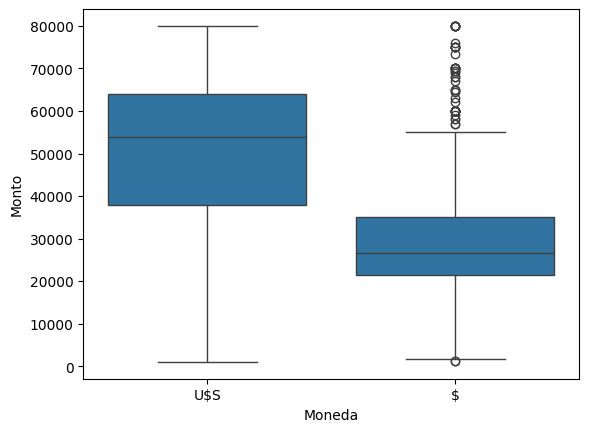

In [194]:
import seaborn as sns

sns.boxplot(x='Moneda', y='Monto', data=df)

<Axes: xlabel='Monto', ylabel='Count'>

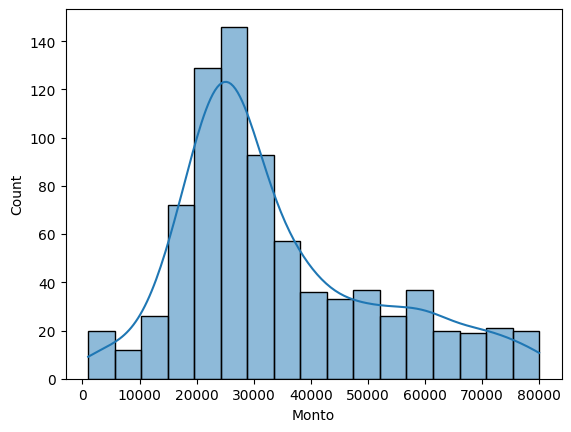

In [195]:
sns.histplot(df['Monto'], kde=True)

In [196]:
df['Año de Construcción'] = df['Año de Construcción'].replace('¡Preguntale!	', np.nan)
df['Año de Construcción'] = pd.to_numeric(df['Año de Construcción'], errors='coerce')


In [198]:
df['Baños'] = pd.to_numeric(df['Baños'], errors='coerce')
df['Dormitorios'] = pd.to_numeric(df['Dormitorios'], errors='coerce')


In [199]:
df['Garajes'] = df['Garajes'].replace('¡Preguntale!', np.nan)
df['Garajes'] = pd.to_numeric(df['Garajes'], errors='coerce')

In [200]:
df['Plantas'] = df['Plantas'].replace('¡Preguntale!', np.nan)
df['Plantas'] = pd.to_numeric(df['Plantas'], errors='coerce')

In [201]:
df = df.drop('Referencia', axis=1)


In [202]:
df['Apartamentos por Pisos'] = df['Apartamentos por Pisos'].replace('¡Preguntale!', np.nan)
df['Apartamentos por Pisos'] = pd.to_numeric(df['Apartamentos por Pisos'], errors='coerce')


In [203]:
df['Piso'] = df['Piso'].replace('¡Preguntale!', np.nan)
df['Piso'] = pd.to_numeric(df['Piso'], errors='coerce')

In [204]:
df['Gastos Comunes'] = df['Gastos Comunes'].replace('¡Preguntale!', np.nan)
df['Gastos Comunes'] = pd.to_numeric(df['Gastos Comunes'], errors='coerce')

In [205]:
df['Hectáreas'] = df['Hectáreas'].replace('¡Preguntale!', np.nan)
df['Hectáreas'] = pd.to_numeric(df['Hectáreas'], errors='coerce')

In [206]:
df['Sobre'] = df['Sobre'].replace('¡Preguntale!', np.nan)
df['Disposición'] = df['Disposición'].replace('¡Preguntale!', np.nan)
df['Zona'] = df['Zona'].replace('¡Preguntale!', np.nan)
df['Barrio Privado'] = df['Barrio Privado'].replace('¡Preguntale!', np.nan)
df['Estado'] = df['Estado'].replace('¡Preguntale!', np.nan)
df['Tipo de Propiedad'] = df['Tipo de Propiedad'].replace('¡Preguntale!', np.nan)
df['Moneda'] = df['Moneda'].replace('¡Preguntale!', np.nan)
df['Vivienda Social'] = df['Vivienda Social'].replace('¡Preguntale!', np.nan)




In [207]:
df['Sobre'] = df['Sobre'].astype('category')
df['Disposición'] = df['Disposición'].astype('category')
df['Zona'] = df['Zona'].astype('category')
df['Barrio Privado'] = df['Barrio Privado'].astype('category')
df['Estado'] = df['Estado'].astype('category')
df['Tipo de Propiedad'] = df['Tipo de Propiedad'].astype('category')
df['Moneda'] = df['Moneda'].astype('category')
df['Vivienda Social'] = df['Vivienda Social'].astype('category')

<Axes: xlabel='Moneda', ylabel='Monto'>

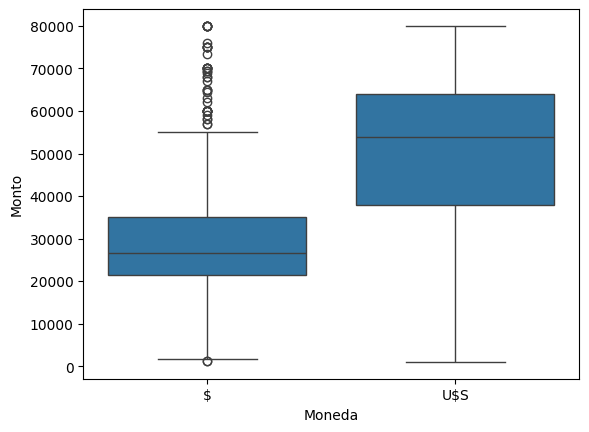

In [208]:
sns.boxplot(x='Moneda', y='Monto', data=df)

In [215]:
df_dummies = pd.get_dummies(df)


221    2497440.0
222    1873080.0
587    1381160.0
220    1248720.0
307     720000.0
         ...    
690          NaN
807          NaN
837          NaN
923          NaN
965          NaN
Name: Monto, Length: 1050, dtype: float64

In [216]:
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Eliminar filas con valores NaN o infinitos en la variable objetivo y
df_dummies_clean = df_dummies.dropna(subset=['Monto'], axis=0).replace([np.inf, -np.inf], np.nan).dropna(subset=['Monto'], axis=0)

# Split the data into features (X) and target variable (y)
X = df_dummies_clean.drop('Monto', axis=1)
y = df_dummies_clean['Monto']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an XGBoost regression model
model = XGBRegressor()

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate the root mean squared error
rmse = mean_squared_error(y_test, y_pred, squared=False)

# Print the root mean squared error
print('Root Mean Squared Error:', rmse)


Root Mean Squared Error: 12268.729023338154


In [256]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Calcular el error en términos de porcentaje del rango de la variable objetivo
def calculate_percentage_error(y_true, y_pred):
    # Calcular el rango de la variable objetivo
    target_range = y_true.max() - y_true.min()
    # Calcular el error cuadrático medio
    mse = mean_squared_error(y_true, y_pred)
    # Calcular el error en porcentaje
    percentage_error = np.sqrt(mse) / target_range * 100
    return percentage_error

# Calcular el error en porcentaje
percentage_error = calculate_percentage_error(y_test, y_pred)

# Imprimir el error en porcentaje
print('Root Mean Squared Error (as percentage of target range): {:.2f}%'.format(percentage_error))


Root Mean Squared Error (as percentage of target range): 23.74%


AttributeError: 'numpy.ndarray' object has no attribute 'select_dtypes'

In [258]:
# Inicializar modelos
linear_reg = LinearRegression()
random_forest = RandomForestRegressor()
gradient_boosting = GradientBoostingRegressor()
hist_gradient_boosting = HistGradientBoostingRegressor()
svr = SVR()
knn = KNeighborsRegressor()
ann = MLPRegressor()

# Lista de modelos
models = [
    ("Linear Regression", linear_reg),
    ("Random Forest", random_forest),
    ("Gradient Boosting", gradient_boosting),
    ("Hist Gradient Boosting", hist_gradient_boosting),
    ("Support Vector Regressor", svr),
    ("K-Nearest Neighbors", knn),
    ("Artificial Neural Network", ann)
]

# Imputador para manejar valores faltantes
imputer = SimpleImputer(strategy='mean')

# Ajustar y evaluar cada modelo
for name, model in models:
    # Preprocesar los datos
    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.transform(X_test)
    
    if name != "Linear Regression":
        # Realizar la búsqueda de cuadrícula para ajustar los hiperparámetros
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
        grid_search.fit(X_train_imputed, y_train)
        best_model = grid_search.best_estimator_
    else:
        best_model = model
        # Ajustar el modelo de regresión lineal
        best_model.fit(X_train_imputed, y_train)  # Asegúrate de ajustar el modelo aquí
    
    # Hacer predicciones
    y_pred = best_model.predict(X_test_imputed)
    
    # Calcular el error cuadrático medio
    mse = mean_squared_error(y_test, y_pred)
    
    # Imprimir el MSE
    print(f"MSE para {name}: {mse:.4f}")


MSE para Linear Regression: 416.8089


ValueError: Invalid parameter 'C' for estimator RandomForestRegressor(). Valid parameters are: ['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'].

NotFittedError: This LinearRegression instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [279]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import numpy as np

# Inicializar modelos
linear_reg = LinearRegression()
random_forest = RandomForestRegressor()
gradient_boosting = GradientBoostingRegressor()
hist_gradient_boosting = HistGradientBoostingRegressor()
svr = SVR()
knn = KNeighborsRegressor()
ann = MLPRegressor()

# Lista de modelos
models = [
    ("Linear Regression", linear_reg),
    ("Random Forest", random_forest),
    ("Gradient Boosting", gradient_boosting),
    ("Hist Gradient Boosting", hist_gradient_boosting),
    ("Support Vector Regressor", svr),
    ("K-Nearest Neighbors", knn),
    ("Artificial Neural Network", ann)
]

# Imputador para manejar valores faltantes
imputer = SimpleImputer(strategy='mean')

# Lista para almacenar los errores de cada modelo
model_errors = []

# Preprocesamiento y separación de datos
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# Entrenar y evaluar cada modelo
for name, model in models:
    # Entrenar el modelo
    model.fit(X_train, y_train)
    
    # Hacer predicciones
    y_pred = model.predict(X_test)
    
    # Calcular el error cuadrático medio
    mse = mean_squared_error(y_test, y_pred)
    
    # Calcular el error en porcentaje del rango de la variable objetivo
    target_range = y_test.max() - y_test.min()
    percentage_error = np.sqrt(mse) / target_range * 100
    
    # Guardar el error junto con el nombre del modelo
    model_errors.append((name, percentage_error))

# Imprimir el error cuadrático medio de cada modelo en porcentaje
for name, error in model_errors:
    print(f"Error cuadrático medio para {name}: {error:.2f}%")


Error cuadrático medio para Linear Regression: 11.31%
Error cuadrático medio para Random Forest: 13.76%
Error cuadrático medio para Gradient Boosting: 14.71%
Error cuadrático medio para Hist Gradient Boosting: 12.46%
Error cuadrático medio para Support Vector Regressor: 21.80%
Error cuadrático medio para K-Nearest Neighbors: 11.41%
Error cuadrático medio para Artificial Neural Network: 23.30%


c:\Users\lucca\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [280]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
import numpy as np

# Definir modelos
linear_reg = LinearRegression()
random_forest = RandomForestRegressor()
gradient_boosting = GradientBoostingRegressor()
hist_gradient_boosting = HistGradientBoostingRegressor()
svr = SVR()
knn = KNeighborsRegressor()
ann = MLPRegressor()

# Lista de modelos
models = [
    ("Linear Regression", linear_reg),
    ("Random Forest", random_forest),
    ("Gradient Boosting", gradient_boosting),
    ("Hist Gradient Boosting", hist_gradient_boosting),
    ("Support Vector Regressor", svr),
    ("K-Nearest Neighbors", knn),
    ("Artificial Neural Network", ann)
]

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocesamiento de datos
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Mejorar el modelo seleccionando el mejor de los modelos existentes
best_model = None
best_mse_percentage = np.inf
for name, model in models:
    model.fit(X_train_processed, y_train)
    y_pred = model.predict(X_test_processed)
    mse = mean_squared_error(y_test, y_pred)
    mse_percentage = (mse / np.var(y_test)) * 100  # Calculamos el porcentaje del MSE
    print(f"MSE para {name}: {mse_percentage:.2f}%")
    if mse_percentage < best_mse_percentage:
        best_model = model
        best_mse_percentage = mse_percentage

# Realizar una búsqueda de cuadrícula para ajustar los hiperparámetros del mejor modelo
param_grid = {
    # Define los hiperparámetros a ajustar
    # Por ejemplo:
    # 'n_estimators': [50, 100, 200],
    # 'max_depth': [None, 5, 10, 20],
}
grid_search = GridSearchCV(estimator=best_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train_processed, y_train)

# Obtener el mejor modelo del GridSearchCV
best_model_improved = grid_search.best_estimator_
print("Mejor modelo encontrado con búsqueda de cuadrícula:", best_model_improved)


MSE para Linear Regression: 19.81%
MSE para Random Forest: 29.20%
MSE para Gradient Boosting: 33.49%
MSE para Hist Gradient Boosting: 24.04%
MSE para Support Vector Regressor: 73.53%
MSE para K-Nearest Neighbors: 20.16%
MSE para Artificial Neural Network: 85.98%
Mejor modelo encontrado con búsqueda de cuadrícula: LinearRegression()


c:\Users\lucca\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


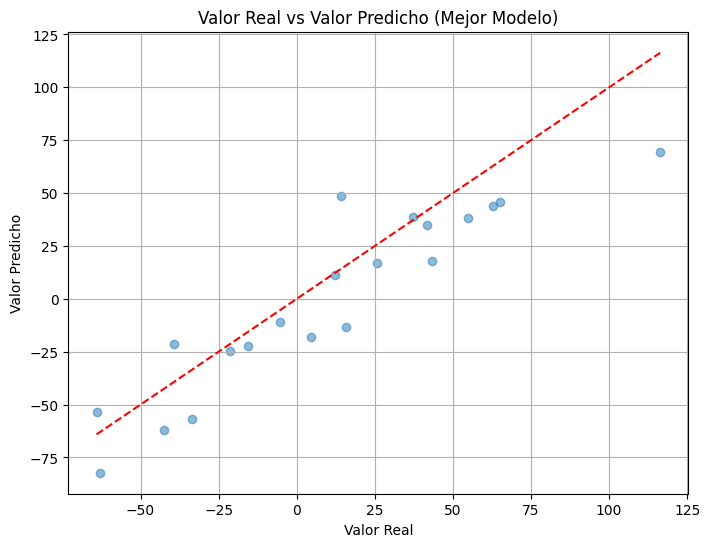

In [281]:
import matplotlib.pyplot as plt

# Hacer predicciones con el mejor modelo
y_pred_best = best_model_improved.predict(X_test_processed)

# Graficar el scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_best, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')  # Línea 1 a 1
plt.xlabel("Valor Real")
plt.ylabel("Valor Predicho")
plt.title("Valor Real vs Valor Predicho (Mejor Modelo)")
plt.grid(True)
plt.show()
